In [50]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

import seaborn as sns

In [51]:
data = pd.read_csv("../data/clean/full_dataset.csv")

In [52]:
data.head()

,ID Number,Preferred Pronouns,Current Grade Level,Program,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Uncomfortable with,Extra activities,...,Application Year,Current Age,Rejected,EECode,EarnHours,EarnRate,EarnAmount,Dist Position Desc,Year,Month
0,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,5.50,13.0,71.50,WILD Steward,2022.0,4.0
1,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,14.47,13.0,188.11,WILD Steward,2022.0,5.0
2,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,7.13,13.0,92.69,WILD Steward,2022.0,5.0
3,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,130.38,13.0,1694.94,WILD Steward,2022.0,6.0
4,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,123.80,13.0,1609.40,WILD Steward,2022.0,7.0


In [53]:
data.columns

Index(['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode', 'EarnHours', 'EarnRate', 'EarnAmount', 'Dist Position Desc',
       'Year', 'Month'],
      dtype='object')

In [54]:


data['Commit Summer'] = data['Commit Summer'].fillna('no').map({'yes':2,'no':0, 'unsure':1})
data['Commit Summer'].unique()

array([2, 1, 0], dtype=int64)

In [55]:
data['Commit Weekday'].unique()
data['Commit Weekday'] = data['Commit Weekday'].fillna('no').map({'yes':2,'no':0, 'unsure':1})
data['Commit Weekday'].unique()

array([2, 1, 0], dtype=int64)

In [56]:
data['Hear about source'].unique()
data['Hear about source'] = data['Hear about source'].fillna('no').map({'no':0, 'other':1, 'friend':2, 'school':2,
'social media':1, 'family':2})
data['Hear about source'].unique()

array([1, 2, 0], dtype=int64)

In [57]:
data['EarnHours'] = data['EarnHours'].fillna(0)
data['Current Grade Level'] = data['Current Grade Level'].fillna(0)
data['Comfortable speaking to crowd'] = data['Comfortable speaking to crowd'].fillna(0)
data['Comfortable speaking to crowd'].unique()

array([1., 0.])

In [58]:
X = data[['Current Grade Level', 'First Paying Job', 'Know employee', 'Applied Before',
'Comfortable speaking to crowd','Extra activities','Commit Summer', 'Commit Weekday',
 'Hear about source', 
]]
X

,Current Grade Level,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Extra activities,Commit Summer,Commit Weekday,Hear about source
0,9.0,1,0,0,1.0,0,2,2,1
1,9.0,1,0,0,1.0,0,2,2,1
2,9.0,1,0,0,1.0,0,2,2,1
3,9.0,1,0,0,1.0,0,2,2,1
4,9.0,1,0,0,1.0,0,2,2,1
...,...,...,...,...,...,...,...,...,...
778,11.0,0,1,0,0.0,0,2,2,2
779,10.0,1,0,0,1.0,0,2,2,1
780,10.0,1,0,0,1.0,0,0,2,2
781,10.0,1,1,0,0.0,0,2,2,2


In [59]:

y =  data[['EarnHours']]
y

,EarnHours
0,5.50
1,14.47
2,7.13
3,130.38
4,123.80
...,...
778,0.00
779,0.00
780,0.00
781,0.00


In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [61]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [62]:
model.coef_

array([[-0.5204772 ,  1.62813134,  2.13729355, -1.57143812, 11.34964398,
         4.52874142,  9.4510752 , 11.5338897 , -6.83498031]])

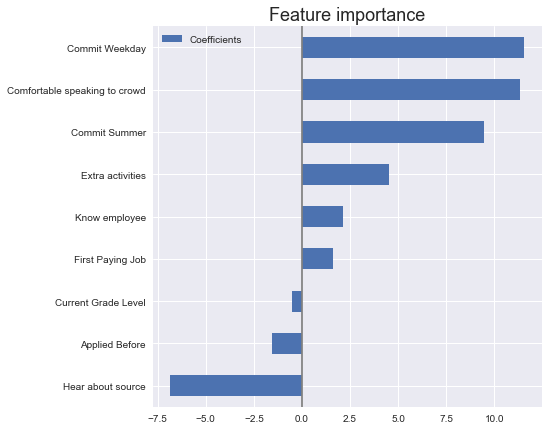

In [63]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_.transpose(),
   columns=['Coefficients'], index=X_train.columns
)
coefs = coefs.sort_values(by=['Coefficients'])
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)



In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(548, 9)
(235, 9)
(548, 1)
(235, 1)


In [65]:


regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 [-6.35540411]
Coefficients: 
 [[-0.25287278  1.21115575  1.12902137  2.26922333  9.7345247   4.61383861
   8.28436892 10.14725287 -7.25641701]]
                                 OLS Regression Results                                
Dep. Variable:              EarnHours   R-squared (uncentered):                   0.395
Model:                            OLS   Adj. R-squared (uncentered):              0.388
Method:                 Least Squares   F-statistic:                              56.24
Date:                Thu, 09 Feb 2023   Prob (F-statistic):                    1.06e-78
Time:                        16:18:51   Log-Likelihood:                         -3780.9
No. Observations:                 783   AIC:                                      7580.
Df Residuals:                     774   BIC:                                      7622.
Df Model:                           9                                                  
Covariance Type:            nonrobust              

In [66]:

plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [67]:
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

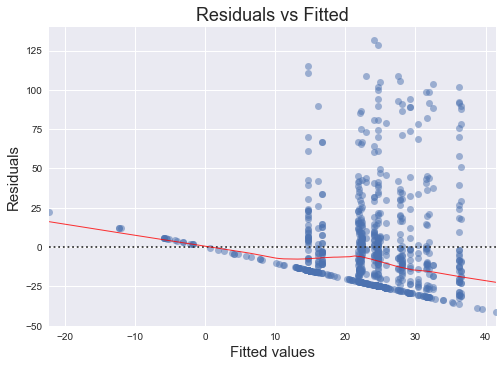

In [68]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

c:\Users\ihkim\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


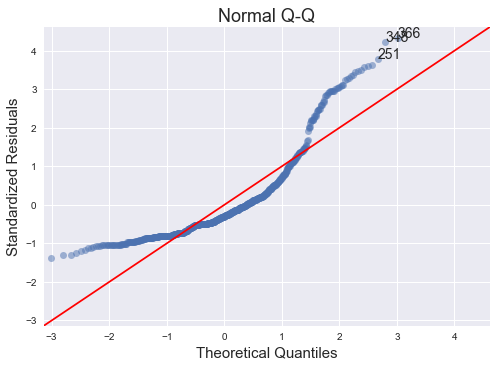

In [69]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]))

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


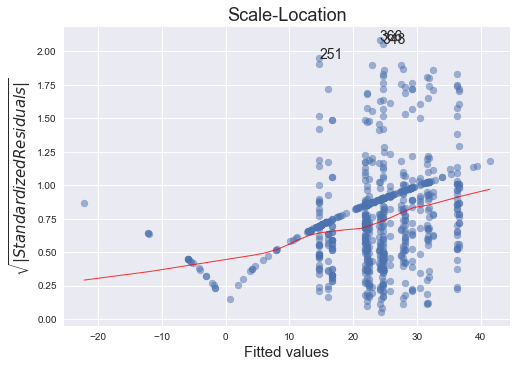

In [70]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                            xy=(model_fitted_y[i],
                            model_norm_residuals_abs_sqrt[i]))

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


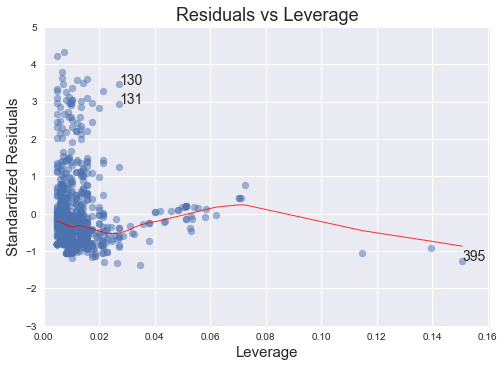

In [71]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
    xy=(model_leverage[i],
        model_norm_residuals[i]))